In [63]:
import pandas as pd
import os

file_path = '../raw/Data/Fire_Weather_Data_2002-2014_2016.csv'
if os.path.exists(file_path):
    # Read the CSV file
    df = pd.read_csv(file_path)

    # Display the first few rows of the DataFrame
    print(df.head())

    # Display the shape of the DataFrame
    print(f"DataFrame shape: {df.shape}")

    # Display the columns of the DataFrame
    print(f"DataFrame columns: {df.columns.tolist()}")

    # Display the data types of each column
    print(f"Data types:\n{df.dtypes}")
    # Display the number of missing values in each column
    print(f"Missing values:\n{df.isnull().sum()}")
else:
    print(f"File not found: {file_path}")
# Check for duplicates
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")
# Check for unique values in the 'State' column
unique_states = df['state'].unique()
print(f"Unique states: {unique_states}")
# Check the number of unique values in the 'State' column
unique_state_count = df['state'].nunique()
print(f"Number of unique states: {unique_state_count}")
# Check the number of unique values in the 'station_verified_in_psa' column
unique_stations = df['station_verified_in_psa'].unique()
print(f"Unique fire weather stations: {unique_stations}")
# Check the number of unique values in the 'station_verified_in_psa' column
unique_station_count = df['station_verified_in_psa'].nunique()
print(f"Number of unique fire weather stations: {unique_station_count}")

   start_year  region_ind incident_number  avrh_mean  wind_med  erc_med  \
0        2002           6     CA-ANF-3518         39         6     77.0   
1        2002           6    CA-AEU-16666         46         1     56.0   
2        2002           6  CA-LAC02172482         19        18     24.0   
3        2002           6   CA-ANF-001751         60         6     26.0   
4        2002           6      CA-INF-602         25         7     20.0   

   rain_sum      region state           incident_name  ...  \
0         0  California    CA  williams/curve complex  ...   
1         0  California    CA            sly park vmp  ...   
2         0  California    CA                  cherry  ...   
3         0  California    CA                 susanna  ...   
4         0  California    CA                   birch  ...   

  control_day_of_year gt_100 dom_strat_ind_75 dom_strat_ind_25  \
0                 288      1                0                0   
1                 294      1                

# Did lightning or humans cause more fires impacting above 100 acres?

In [64]:
df['acres'] = df['hec'] * 2.741

In [65]:
# Group the data by 'cause' for rows where 'acres' > 100 and count the occurrences
grouped_table = df[df['acres'] > 100].groupby(['cause']).size().reset_index(name='count')

# Display the table
print(grouped_table)

  cause  count
0     H   1691
1     L   3593
2     N     52
3     O      4
4     U   1310


In [69]:
df['gt_100'].unique()

array([1])

# How many more or less fatalities occurred due to wildfires on days with humidity less than 30% compared to the average? Positive numbers indicate more, and negative numbers will indicate less.

In [25]:
average_fatalities = df[df['avrh_mean'] < 30]['fatalities_last'].mean()
print(f"Average fatalities: {average_fatalities}")

Average fatalities: 0.01288404360753221


In [26]:
average_fatalities - df['fatalities_last'].mean()

-0.005289582105895245

# Which state has the most land impacted by fire, per capita?

In [59]:
import fitz  # PyMuPDF
import re
import pandas as pd

# Path to your downloaded PDF file
pdf_path = "../studies/annual_report_2024.pdf"

# Load the PDF
doc = fitz.open(pdf_path)

# Extract text from pages 45 to 54 (page indices 41 to 50)
text = ""
for page_num in range(42, 54):
    text += doc.load_page(page_num).get_text()

# Step 1: Match state headers and their positions
state_pattern = r"\n([A-Z][a-z]+(?: [A-Z][a-z]+)?)\s+Agency\s+Fires\s+-"
state_matches = list(re.finditer(state_pattern, text))
state_positions = [m.start() for m in state_matches]
state_names = [m.group(1) for m in state_matches]

# Step 2: Match totals lines (we only want the last column = total acres)
totals_pattern = r"Totals:\s+(?:\d[\d,]*\s+){5}(\d[\d,]*)"
totals_matches = list(re.finditer(totals_pattern, text))

# Step 3: Match each totals line with the nearest preceding state
wildfire_acres_by_state = {}
for match in totals_matches:
    total_pos = match.start()
    total_acres = int(match.group(1).replace(",", ""))

    # Find the closest previous state header
    preceding_states = [i for i, pos in enumerate(state_positions) if pos < total_pos]
    if preceding_states:
        state_idx = preceding_states[-1]
        state = state_names[state_idx]
        wildfire_acres_by_state[state] = total_acres

# Optional: Convert to DataFrame and display/save
df = pd.DataFrame(wildfire_acres_by_state.items(), columns=["State", "Total Acres Burned"])
print(df)

# Optionally save to CSV
# df.to_csv("wildfire_acres_by_state.csv", index=False)

             State  Total Acres Burned
0          Alabama               20978
1           Alaska              667075
2          Arizona              282989
3         Arkansas               25444
4       California             1081144
5         Colorado               60539
6      Connecticut                 339
7         Delaware                 137
8          Florida               65618
9          Georgia               11896
10          Hawaii                 452
11           Idaho              996762
12        Illinois                 441
13         Indiana                 154
14            Iowa                3965
15          Kansas               22217
16        Kentucky               24448
17       Louisiana                9058
18           Maine                 295
19        Maryland                 965
20   Massachusetts                4622
21        Michigan                2062
22       Minnesota               15125
23     Mississippi               55880
24        Missouri       

In [ ]:
import re

raw_data = """
Alabama
Agency Fires -
Human Acres - Human Fires –
Lightning 55 2,262 Acres – Lightning Fires – Total Acres - Total
FS 3 897 58 3,159
FWS 2 203 1 399 3 602
NPS 2 1 0 0 2 1
ST 1,363 17,216 99 0 1,462 17,216
Totals: 1,422 19,682 103 1,296 1,525 20,978
Alaska
Agency Fires -
Human Acres - Human Fires –
Lightning Acres – Lightning Fires – Total Acres - Total
BLM 36 2,742 104 551,024 140 553,766
DVF 150 769 75 112,540 225 113,308
FS 11 1 1 0 12 1
Totals: 197 3,512 180 663,564 377 667,075
Arizona
Agency Fires -
Human Acres - Human Fires –
Lightning Acres – Lightning Fires – Total Acres - Total
BIA 604 13,674 152 21,590 756 35,264
BLM 129 3,841 104 39,660 233 43,501
DVF 297 31,963 44 46,839 341 78,802
FS 373 36,953 455 85,450 828 122,402
FWS 8 1,341 1 1,422 9 2,763
NPS 11 1 13 256 24 257
Totals: 1,422 87,773
Arkansas
Agency Fires -
Human Acres - Human Fires –
Lightning Acres – Lightning Fires – Total Acres - Total
23,714 FS 1,189 769 195,217 2,191 282,989
0 0 1,189 23,714
FWS 4 51 0 0 4 51
NPS 26 1,679 0 0 26 1,679
Totals: 1,219 25,444 0 0 1,219 25,444
California
Agency Fires -
Human Acres - Human Fires –
Lightning Acres – Lightning Fires – Total Acres - Total
BIA 48 898 0 0 48 898
BLM 92 10,670 34 2,833 126 13,503
C&L 47 87,337 0 0 47 87,336
CDF 7,075 503,944 12 934 7,087 504,878
FS 688 385,744 224 71,558 912 457,302
FWS 3 8 0 0 3 8
NPS 46 33 35 14,881 81 14,913
USA 6 2,299 0 0 6 2,299
42
Agency Fires -
Human Acres - Human Fires –
Lightning Acres – Lightning Fires – Total Acres - Total
USAF 6 6 0 0 6 6
Totals: 8,011 990,939 305 90,206 8,316 1,081,144
Colorado
Agency Fires -
Human Acres - Human Fires –
Lightning BIA BLM BOR 1 0 C&L FS FWS NPS USA USAF Totals: 
Agency Fires -
Human Acres - Human Fires –
Lightning Acres – Lightning Fires – Total Acres - Total
ST  12 54 173 108 14 356 56 3,944 11,366 16,622 13,277 339
Acres – Lightning Fires – Total Acres - Total
45 27 57 83
262 1,703 316 5,647
1 0 2 0
92 4,423 265 15,788
102 8,287 210 24,909
3 40 1 3 4 43
7 0 16 133 23 133
2 566 16 13,842
1 92 0 0 1 92
373 45,398 521 15,142 894 60,539
Connecticut
0 0 356 339
Totals: 356 339 0 0 356 339
Delaware
Agency Fires -
Human Acres - Human Fires –
Lightning Acres – Lightning Fires – Total Acres - Total
ST 23 137 0 0 23 137
Totals: 23 137 0 0 23 137
Florida
Agency Fires -
Human Acres - Human Fires –
Lightning Acres – Lightning Fires – Total Acres - Total
BIA 3 1 0 0 3 1
DOD 0 0 1 833 1 833
FS 69 6,772 11 923 80 7,695
FWS 6 166 4 4,901 10 5,067
NPS 12 818 4 12 16 830
OTHR 11 52 2 1 13 53
ST 1,805 27,430 420 23,709 2,225 51,139
Totals: 1,906 35,239 442 30,379 2,348 65,618
Georgia
Agency Fires -
Human Acres - Human Fires –
Lightning Acres – Lightning Fires – Total Acres - Total
FS 35 327 2 2 37 329
FWS 1 1 0 0 1 1
NPS 1 10 0 0 1 10
ST 2,453 11,556 0 0 2,453 11,556
Totals: 2,490 11,894 2 2 2,492 11,896
43
Hawaii
Agency Fires -
Human Acres - Human Fires –
Lightning 74 Acres – Lightning Fires – Total Acres - Total
C&L 88 1 300 89 374
NPS 0 0 1 78 1 78
Totals: 88 74 2 378 90 452
Idaho
Agency Fires -
Human Acres - Human Fires –
Lightning Acres – Lightning Fires – Total Acres - Total
BIA 38 3,074 5 29,020 43 32,094
BLM 138 21,059 91 288,502 229 309,561
BOR 3 8 0 0 3 8
C&L 34 734 2 60 36 794
DOD 0 0 2 142 2 142
FS 94 3,476 407 569,677 501 573,153
FWS 1 0 1 114 2 114
ST 511 42,160 123 38,736 634 80,896
Totals: 819 70,511 631 926,251 1,450 996,762
Illinois
Agency Fires -
Human Acres - Human Fires –
Lightning Acres – Lightning Fires – Total Acres - Total
FS 39 380 0 0 39 379
FWS 6 15 0 0 6 15
ST 2 47 0 0 2 47
Totals: 47 442 0 0 47 441
Indiana
Agency Fires -
Human Acres - Human Fires –
Lightning Acres – Lightning Fires – Total Acres - Total
42 FS 14 0 0 14 42
NPS 44 34 0 0 44 34
ST 6 78 0 0 6 78
Totals: 64 154 0 0 64 154
Iowa
Agency Fires -
Human Acres - Human Fires –
Lightning Acres – Lightning Fires – Total Acres - Total
DNR 355 3,152 0 0 355 3,152
FWS 7 813 0 0 7 813
Totals: 362 3,965 0 0 362 3,965
Kansas
Agency Fires -
Human Acres - Human Fires –
Lightning Acres – Lightning Fires – Total Acres - Total
273 BIA 12 0 0 12 272
C&L 23 21,818 0 0 23 21,818
FWS 5 126 1 1 6 126
Totals: 40 22,217 1 1 41 22,217
44
Kentucky
Agency Fires -
Human Acres - Human Fires –
Lightning Acres – Lightning Fires – Total Acres - Total
FS 24 525 0 0 24 525
ST 933 23,923 0 0 933 23,923
Totals: 957 24,448 0 0 957 24,448
Louisiana
Agency Fires -
Human Acres - Human Fires –
Lightning Acres – Lightning Fires – Total Acres - Total
218 FS 15 3 14 18 232
FWS 0 0 1 2,830 1 2,830
ST 366 5,996 0 0 366 5,996
Totals: 381 6,214 4 2,844 385 9,058
Maine
Agency Fires -
Human Acres - Human Fires –
Lightning Acres – Lightning Fires – Total Acres - Total
NPS 3 0 0 0 3 0
ST 650 295 0 0 650 295
Totals: 653 295 0 0 653 295
Maryland
Agency Fires -
Human Acres - Human Fires –
Lightning Acres – Lightning Fires – Total Acres - Total
FWS 3 2 0 0 3 2
NPS 5 2 1 0 6 2
ST 163 961 2 0 165 961
Totals: 171 965 3 0 174 965
Massachusetts
Agency Fires -
Human Acres - Human Fires –
Lightning Acres – Lightning Fires – Total Acres - Total
ST 1,297 4,622 2 0 1,299 4,622
Totals: 1,297 4,622 2 0 1,299 4,622
Michigan
Agency Fires -
Human Acres - Human Fires –
Lightning Acres – Lightning Fires – Total Acres - Total
BIA DNR FS NPS 0 0 ST 4 1 Totals: Minnesota
DNR 13 279 130 426 188 890 20 1,339 271 1,631 883 13,475 0 0 13 20
16 102 295 1,441
5 329 135 600
0 0 0 0
0 0 4 1
21 431 447 2,062
Agency Fires -
Human Acres - Human Fires –
Lightning Acres – Lightning Fires – Total Acres - Total
BIA 0 0 188 883
0 0 890 13,475
45
FS 0 0 33 431
FWS 0 0 11 335
NPS 0 0 1 1 1 1
Totals: 1 1 1,123 15,125
Mississippi
Agency Fires -
Human Acres - Human Fires –
Lightning Acres – Lightning Fires – Total Acres - Total
33 11 1,122 10 167 20 431 335 15,124 20 15,672 408 Agency Fires -
Human Acres - Human Fires –
Lightning Acres – Lightning Fires – Total Acres - Total
BIA 0 0 10 20
FS 4 122 171 15,794
FWS 8 25 0 0 8 25
NPS 0 0 20 408
OTHR 1,591 39,633 0 0 1,591 39,633
Totals: 1,796 55,758 4 122 1,800 55,880
Missouri
Agency Fires -
Human Acres - Human Fires –
Lightning Acres – Lightning Fires – Total Acres - Total
11,607 FS 164 0 0 164 11,607
NPS 3 58 0 0 3 58
ST 2,637 83,430 0 0 2,637 83,430
Totals: 2,804 95,095 0 0 2,804 95,095
Montana
Agency Fires -
Human Acres - Human Fires –
Lightning Acres – Lightning Fires – Total Acres - Total
BIA 372 9,550 44 2,227 416 11,777
BLM 29 478 65 176,074 94 176,552
C&L 775 45,680 263 57,265 1,038 102,945
FS 243 22,863 269 32,468 512 55,331
FWS 4 123 9 1,797 13 1,920
NPS 2 0 6 30 8 30
ST 157 947 85 2,988 242 3,936
Totals: 1,582 79,641 741 272,849 2,323 352,491
Nebraska
BIA 6 263 0 0 6 263
DOF 107 10,120 1,006 112,066
FS 2 0 16 1,227 18 1,227
FWS 2 284 2 0 4 284
Nevada
Agency Fires -
Human Acres - Human Fires –
Lightning Acres – Lightning Fires – Total Acres - Total
101,946 102,503 345 TNC 1 10 Totals: Agency Fires -
Human Acres - Human Fires –
Lightning BLM 899 910 20,169 0 0 1 10
125 11,347 1,035 113,850
Acres – Lightning Fires – Total Acres - Total
225 23,263 570 43,432
46
BOR C&L 37 2,893 182 9,289
DOD 2 8,026 1 0 3 8,026
FS 45 9,067 66 9,076
FWS 2 0 2 98 4 98
NPS 4 12 478 41 482
Agency Fires -
Human Acres - Human Fires –
Lightning Acres – Lightning Fires – Total Acres - Total
56 5 0 0 56 5
145 21 29 605 6,397 10 34,612 New Hampshire
Agency Fires -
Human Acres - Human Fires –
Lightning 123 ST 5 1 2 0 7 1
Totals: 324 35,799 929 70,410
Acres – Lightning Fires – Total Acres - Total
FS 3 1 0 0 3 1
ST 125 4 1 127 126
Totals: 126 126 4 1 130 127
New Jersey
Agency Fires -
Human Acres - Human Fires –
Lightning Acres – Lightning Fires – Total Acres - Total
FWS 4 25 0 0 4 25
NPS 1 0 0 0 1 0
ST 1,438 12,424 0 0 1,438 12,424
Totals: 1,443 12,449 0 0 1,443 12,449
BIA BLM DOE 1 1 FS FWS 0 0 NPS 2 1 New Mexico
73 44 95 235 451 8,057 123 848 2,966 11,995 6,495 Agency Fires -
Human Acres - Human Fires –
Lightning Acres – Lightning Fires – Total Acres - Total
44 17,709 117 25,766
36 238 80 361
0 0 1 1
201 47,663 296 48,510
2 98 2 98
13 1,670 15 1,671
SF 76 3,158 311 6,123
USA 1 0 0 0 1 0
Totals: 372 70,536 823 82,531
New York
Agency Fires -
Human Acres - Human Fires –
Lightning Acres – Lightning Fires – Total Acres - Total
NPS 3 0 0 0 3 0
ST 119 3 1 122 6,496
Totals: 122 6,495 3 1 125 6,496
North Carolina
Agency Fires -
Human Acres - Human Fires –
Lightning Acres – Lightning Fires – Total Acres - Total
BIA 13 13 0 0 13 13
FS 40 999 2 2 42 1,001
47
Agency Fires -
Human Acres - Human Fires –
Lightning Acres – Lightning Fires – Total Acres - Total
FWS 0 227 0 0 0 227
NPS 5 1 0 0 5 1
ST 4,535 15,345 53 361 4,588 15,706
USM 20 1,285 0 0 20 1,285
Totals: 4,613 17,870 55 363 4,668 18,233
BIA BLM 1 145 North Dakota
369 12 10 18,810 9,340 1,100 143,732 Agency Fires -
Human Acres - Human Fires –
Lightning Acres – Lightning Fires – Total Acres - Total
2 12 371 18,822
0 0 1 145
FS 2 42 14 9,382
FWS 0 0 10 1,100
NPS 2 8 2 11 4 19
ST 522 13 37 535 143,769
Totals: 916 173,135 19 102 935 173,237
Ohio
Agency Fires -
Human Acres - Human Fires –
Lightning Acres – Lightning Fires – Total Acres - Total
FS 45 48 0 0 45 48
ST 1,054 2,383 8 10 1,062 2,393
Totals: 1,099 2,431 8 10 1,107 2,441
Oklahoma
Agency Fires -
Human Acres - Human Fires –
Lightning Acres – Lightning Fires – Total Acres - Total
BIA 0 0 944 70,757
FWS 3 12,423 0 0 3 12,423
NPS 1 0 0 0 1 0
OTHR 0 0 389 3,177
ST 5 1,835 1,696 297,014
TRIBE 8 220 0 0 8 220
Totals: 5 1,835 3,041 383,592
Oregon
944 70,757 389 3,177 1,691 295,179 3,036 381,757 Agency Fires -
Human Acres - Human Fires –
Lightning Acres – Lightning Fires – Total Acres - Total
100 857 158 341,534 780 34,696 299 145,648 1,345 522,751 BIA 5 33 105 889
BLM 147 746,161 305 1,087,695
C&L 2 14 3 0 5 14
DOF 218 120,841 998 155,537
FS 500 335,562 799 481,210
FWS 3 1 7 67,157 10 67,158
NPS 3 1 7 5,292 10 5,293
Totals: 887 1,275,046 2,232 1,797,796
48
Pennsylvania
Agency Fires -
Human Acres - Human Fires –
Lightning Acres – Lightning FS 7 1 0 0 NPS 14 628 0 0 ST 1,423 3,161 4 2 Totals: 1,444 3,790 4 2 Rhode Island
Agency Fires -
Human Acres - Human Fires –
Lightning Acres – Lightning ST 73 75 0 0 Totals: 73 75 0 0 South Carolina
Agency Fires -
Human Acres - Human Fires –
Lightning Acres – Lightning FS 49 634 1 0 Totals: 49 634 1 0 BIA BLM 3 16 C&L FS FWS 3 87 NPS 1 0 ST Tennessee
South Dakota
379 30 42 70 531 31 523 21,509 744 53 315 22,724 351 6,400 Agency Fires -
Human Acres - Human Fires –
Lightning Acres – Lightning 39 491 1 0 8 9,952 62 557 0 0 2 1,981 32 104 USA 1 0 0 0 USAF 2 0 0 0 Totals: 144 13,085 Agency Fires -
Human Acres - Human Fires –
Lightning Acres – Lightning FS 2 60 NPS 7 55 0 0 OTHR 10 154 ST 22 750 1 1 Totals: 583 7,556 13 215 Texas
Agency Fires -
Human Acres - Human Fires –
Lightning Acres – Lightning BLM 0 0 0 0 C&L 4,148 14,553 132 1,681 FS 41 1,279 1 0 FWS 7 689 1 0 NPS 34 162 4 13,519 OTHR 4 1 0 0 Fires – Total Acres - Total
7 1
14 628
1,427 3,163
1,448 3,792
Fires – Total Acres - Total
73 75
73 75
Fires – Total Acres - Total
50 634
50 634
Fires – Total Acres - Total
418 22,000
4 16
38 10,696
104 610
3 87
3 1,981
102 419
1 0
2 0
675 35,809
Fires – Total Acres - Total
33 411
7 55
533 6,554
23 751
596 7,771
Fires – Total Acres - Total
0 0
4,280 16,234
42 1,279
8 689
38 13,681
4 1
49
Agency Fires -
Human Acres - Human Fires –
Lightning Acres – Lightning Fires – Total Acres - Total
ST 562 1,277,517 33 5,502 595 1,283,019
Totals: 4,796 1,294,201 171 20,702 4,967 1,314,903
Utah
Agency Fires -
Human Acres - Human Fires –
Lightning Acres – Lightning Fires – Total Acres - Total
BIA BLM DOD 9 5,328 FS FWS NPS ST 18 118 2,894 5 14 611 32 616
16,787 199 3,882 317 20,669
0 0 9 5,328
84 39,634 120 17,960 204 57,594
1 137 0 0 1 137
3 0 10 46 13 46
514 121 3,131 635 6,026
Totals: 747 64,786 464 25,631 1,211 90,417
Vermont
Agency Fires -
Human Acres - Human Fires –
Lightning Acres – Lightning Fires – Total Acres - Total
FS 2 1 1 0 3 1
ST 93 179 1 0 94 179
Totals: 95 180 2 0 97 180
Virginia
Agency Fires -
Human Acres - Human Fires –
Lightning Acres – Lightning Fires – Total Acres - Total
FS 46 19,701 6 7 52 19,708
FWS 3 0 0 0 3 0
OTHR 0 10,298 0 0 0 10,298
ST 683 26,343 4 23 687 26,366
Totals: 732 56,342 10 30 742 56,372
Washington
Agency Fires -
Human Acres - Human Fires –
Lightning Acres – Lightning Fires – Total Acres - Total
BIA 160 7,719 24 53,793 184 61,512
BLM 45 13,331 6 336 51 13,667
C&L 70 6,443 1 0 71 6,443
DNR 969 58,650 96 8,306 1,065 66,956
FS 129 22,340 103 14,591 232 36,931
FWS 22 972 1 1 23 973
NPS 32 9 11 1,553 43 1,562
ST 135 0 0 TRIBE 2 15 0 0 Totals: 242 1,564 87,533 197,012 West Virginia
Agency Fires -
Human Acres - Human Fires –
Lightning FS 20 49 0 0 135 87,533
2 15
78,580 1,806 275,593
Acres – Lightning Fires – Total Acres - Total
20 49
50
Agency Fires -
Human Acres - Human Fires –
Lightning Acres – Lightning Fires – Total Acres - Total
NPS 11 245 0 0 11 245
ST 1,073 55,015 0 0 1,073 55,015
Totals: 1,104 55,309 0 0 1,104 55,309
Wisconsin
Agency Fires -
Human Acres - Human Fires –
Lightning Acres – Lightning Fires – Total Acres - Total
BIA 6 2 0 0 6 2
DNR 1,106 2,503 31 26 1,137 2,529
FS 16 32 1 26 17 58
FWS 2 8 0 0 2 8
NPS 0 0 0 0 0 0
Totals: 1,130 2,545 32 52 1,162 2,597
Wyoming
Agency Fires -
Human Acres - Human Fires –
Lightning Acres – Lightning Fires – Total Acres - Total
BIA 67 465 21 33,944 88 34,409
BLM 68 7,581 73 46,998 141 54,579
C&L 201 68,602 123 268,769 324 337,371
FS 64 12,753 76 149,213 140 161,966
FWS 0 0 2 18 2 18
NPS 6 3 4 0 10 3
SF 14 4,356 19 27,367 33 31,723
Totals: 420 93,760 318 526,309 738 620,069
"""

# We'll assume `raw_data` contains the full text block from the user's message

# Find all "State" blocks and extract the last number from each "Totals:" line (i.e., the total acres)
pattern = r'(?P<state>[A-Z][a-z]+(?: [A-Z][a-z]+)*)\s+.*?Totals:[^\n]*?(\d[\d,]*)\s*$'

# Extract using regex and build dictionary
matches = re.findall(pattern, raw_data, re.DOTALL | re.MULTILINE)
state_acres = {state: int(acres.replace(",", "")) for state, acres in matches}

state_acres


{'Alabama': 20978,
 'Alaska': 667075,
 'Arizona': 87773,
 'Arkansas': 25444,
 'California': 1081144,
 'Colorado': 339,
 'Delaware': 137,
 'Florida': 65618,
 'Georgia': 11896,
 'Hawaii': 452,
 'Idaho': 996762,
 'Illinois': 441,
 'Indiana': 154,
 'Iowa': 3965,
 'Kansas': 22217,
 'Kentucky': 24448,
 'Louisiana': 9058,
 'Maine': 295,
 'Maryland': 965,
 'Massachusetts': 4622,
 'Michigan': 15125,
 'Mississippi': 55880,
 'Missouri': 95095,
 'Montana': 352491,
 'Nebraska': 70410,
 'Acres': 127,
 'New Jersey': 12449,
 'New Mexico': 82531,
 'New York': 6496,
 'North Carolina': 18233,
 'North Dakota': 173237,
 'Ohio': 2441,
 'Oklahoma': 383592,
 'Oregon': 1797796,
 'Pennsylvania': 1314903,
 'Utah': 90417,
 'Vermont': 180,
 'Virginia': 56372,
 'Washington': 55309,
 'Wisconsin': 2597,
 'Wyoming': 620069}

In [45]:
lines = """
.Alabama	5,157,699
.Alaska	740,133
.Arizona	7,582,384
.Arkansas	3,088,354
.California	39,431,263
.Colorado	5,957,493
.Connecticut	3,675,069
.Delaware	1,051,917
.District of Columbia	702,250
.Florida	23,372,215
.Georgia	11,180,878
.Hawaii	1,446,146
.Idaho	2,001,619
.Illinois	12,710,158
.Indiana	6,924,275
.Iowa	3,241,488
.Kansas	2,970,606
.Kentucky	4,588,372
.Louisiana	4,597,740
.Maine	1,405,012
.Maryland	6,263,220
.Massachusetts	7,136,171
.Michigan	10,140,459
.Minnesota	5,793,151
.Mississippi	2,943,045
.Missouri	6,245,466
.Montana	1,137,233
.Nebraska	2,005,465
.Nevada	3,267,467
.New Hampshire	1,409,032
.New Jersey	9,500,851
.New Mexico	2,130,256
.New York	19,867,248
.North Carolina	11,046,024
.North Dakota	796,568
.Ohio	11,883,304
.Oklahoma	4,095,393
.Oregon	4,272,371
.Pennsylvania	13,078,751
.Rhode Island	1,112,308
.South Carolina	5,478,831
.South Dakota	924,669
.Tennessee	7,227,750
.Texas	31,290,831
.Utah	3,503,613
.Vermont	648,493
.Virginia	8,811,195
.Washington	7,958,180
.West Virginia	1,769,979
.Wisconsin	5,960,975
.Wyoming	587,618
	
.Puerto Rico	3,203,295
"""

# Remove any empty lines and reattempt parsing
clean_lines = [line.lstrip(".") for line in lines.splitlines() if line.strip()]
population_dict = {}

for line in clean_lines:
    state, pop = line.split("\t")
    population_dict[state.strip()] = int(pop.replace(",", ""))

population_dict


{'Alabama': 5157699,
 'Alaska': 740133,
 'Arizona': 7582384,
 'Arkansas': 3088354,
 'California': 39431263,
 'Colorado': 5957493,
 'Connecticut': 3675069,
 'Delaware': 1051917,
 'District of Columbia': 702250,
 'Florida': 23372215,
 'Georgia': 11180878,
 'Hawaii': 1446146,
 'Idaho': 2001619,
 'Illinois': 12710158,
 'Indiana': 6924275,
 'Iowa': 3241488,
 'Kansas': 2970606,
 'Kentucky': 4588372,
 'Louisiana': 4597740,
 'Maine': 1405012,
 'Maryland': 6263220,
 'Massachusetts': 7136171,
 'Michigan': 10140459,
 'Minnesota': 5793151,
 'Mississippi': 2943045,
 'Missouri': 6245466,
 'Montana': 1137233,
 'Nebraska': 2005465,
 'Nevada': 3267467,
 'New Hampshire': 1409032,
 'New Jersey': 9500851,
 'New Mexico': 2130256,
 'New York': 19867248,
 'North Carolina': 11046024,
 'North Dakota': 796568,
 'Ohio': 11883304,
 'Oklahoma': 4095393,
 'Oregon': 4272371,
 'Pennsylvania': 13078751,
 'Rhode Island': 1112308,
 'South Carolina': 5478831,
 'South Dakota': 924669,
 'Tennessee': 7227750,
 'Texas': 3129

In [60]:
df_combined = pd.read_csv('../input/Wildfire_Acres_by_State.csv').merge(pd.DataFrame({
    'State': population_dict.keys(),
    'Population': population_dict.values(),
}), on='State', how='outer')
print(df_combined)

                   State  Total Acres Burned  Population
0                Alabama             20978.0     5157699
1                 Alaska            667075.0      740133
2                Arizona            282989.0     7582384
3               Arkansas             25444.0     3088354
4             California           1081144.0    39431263
5               Colorado             60539.0     5957493
6            Connecticut               339.0     3675069
7               Delaware               137.0     1051917
8                Florida             65618.0    23372215
9                Georgia             11896.0    11180878
10                Hawaii               452.0     1446146
11                 Idaho            996762.0     2001619
12              Illinois               441.0    12710158
13               Indiana               154.0     6924275
14                  Iowa              3965.0     3241488
15                Kansas             22217.0     2970606
16              Kentucky       

In [61]:
# Dictionary to modify state entries
state_acres_update = {
    'Pennsylvania': 3792,
    'Rhode Island': 75,
    'South Carolina': 634,
    'South Dakota': 35809,
    'Tennessee': 7771,
    'Texas': 1314903,
    'Utah': 90417,
    'Vermont': 180,
    'Virginia': 56372,
    'Washington': 275593,
    'West Virginia': 55309,
    'Wisconsin': 2597,
    'Wyoming': 620069,
}

# Update the 'Total Acres Burned' column based on the dictionary
df_combined['Total Acres Burned'] = df_combined['State'].map(state_acres_update).fillna(df_combined['Total Acres Burned'])

# Display the updated DataFrame
print(df_combined)

                   State  Total Acres Burned  Population
0                Alabama             20978.0     5157699
1                 Alaska            667075.0      740133
2                Arizona            282989.0     7582384
3               Arkansas             25444.0     3088354
4             California           1081144.0    39431263
5               Colorado             60539.0     5957493
6            Connecticut               339.0     3675069
7               Delaware               137.0     1051917
8                Florida             65618.0    23372215
9                Georgia             11896.0    11180878
10                Hawaii               452.0     1446146
11                 Idaho            996762.0     2001619
12              Illinois               441.0    12710158
13               Indiana               154.0     6924275
14                  Iowa              3965.0     3241488
15                Kansas             22217.0     2970606
16              Kentucky       

In [48]:
df_combined['acres per capita'] = df_combined['Total Acres Burned'] / df_combined['Population']
df_combined

,State,Total Acres Burned,Population,acres per capita
0,Alabama,20978.0,5157699,0.004067
1,Alaska,667075.0,740133,0.901291
2,Arizona,282989.0,7582384,0.037322
3,Arkansas,25444.0,3088354,0.008239
4,California,1081144.0,39431263,0.027418
5,Colorado,60539.0,5957493,0.010162
6,Connecticut,339.0,3675069,0.000092
7,Delaware,137.0,1051917,0.000130
8,Florida,65618.0,23372215,0.002808
9,Georgia,11896.0,11180878,0.001064


In [49]:
df_combined.loc[df_combined['acres per capita'].idxmax()]

State                  Wyoming
Total Acres Burned    620069.0
Population              587618
acres per capita      1.055225
Name: 50, dtype: object

# Are there more fires in Democratic states or Republican states?

In [50]:
democrat_or_republican = pd.read_csv('../input/democratic_vs_republican_votes_by_usa_state_2020.csv')
democrat_or_republican['party'] = democrat_or_republican['percent_democrat'].apply(lambda x: 'democrat' if x >= 50 else 'republican')
democrat_or_republican

,state,DEM,REP,usa_state,usa_state_code,percent_democrat,party
0,Alabama,843473,1434159,Alabama,AL,37.032892,republican
1,Alaska,45758,80999,Alaska,AK,36.098993,republican
2,Arizona,1643664,1626679,Arizona,AZ,50.259682,democrat
3,Arkansas,420985,761251,Arkansas,AR,35.609218,republican
4,California,9315259,4812735,California,CA,65.934760,democrat
5,Colorado,1753416,1335253,Colorado,CO,56.769307,democrat
6,Connecticut,1059252,699079,Connecticut,CT,60.241900,democrat
7,Delaware,295413,199857,Delaware,DE,59.646859,democrat
8,District of Columbia,258561,14449,District of Columbia,DC,94.707520,democrat
9,Florida,5294767,5667834,Florida,FL,48.298456,republican


In [51]:
df_combined = df_combined.merge(pd.DataFrame({
    'State': democrat_or_republican['state'],
    'party': democrat_or_republican['party'],
}), on='State', how='outer')
print(df_combined)

                   State  Total Acres Burned  Population  acres per capita  \
0                Alabama             20978.0     5157699          0.004067   
1                 Alaska            667075.0      740133          0.901291   
2                Arizona            282989.0     7582384          0.037322   
3               Arkansas             25444.0     3088354          0.008239   
4             California           1081144.0    39431263          0.027418   
5               Colorado             60539.0     5957493          0.010162   
6            Connecticut               339.0     3675069          0.000092   
7               Delaware               137.0     1051917          0.000130   
8                Florida             65618.0    23372215          0.002808   
9                Georgia             11896.0    11180878          0.001064   
10                Hawaii               452.0     1446146          0.000313   
11                 Idaho            996762.0     2001619        

In [52]:
import fitz  # PyMuPDF
import re
import pandas as pd

# Load PDF
pdf_path = "../studies/annual_report_2024.pdf"
doc = fitz.open(pdf_path)

# Extract text from pages 45–54 (0-indexed: 44–53)
text = ""
for page_num in range(44, 54):
    text += doc.load_page(page_num).get_text()

# Patterns
state_pattern = r"\n([A-Z][a-z]+(?: [A-Z][a-z]+)?)\s+Agency\s+Fires\s+-"
totals_fires_pattern = r"Totals:\s+(?:\d[\d,]*\s+){4}(\d[\d,]*)\s+\d[\d,]*"

# Match states and totals
state_matches = list(re.finditer(state_pattern, text))
state_positions = [m.start() for m in state_matches]
state_names = [m.group(1) for m in state_matches]

fires_matches = list(re.finditer(totals_fires_pattern, text))

# Link totals to nearest preceding state
wildfire_fires_by_state = {}
for match in fires_matches:
    total_pos = match.start()
    total_fires = int(match.group(1).replace(",", ""))

    preceding_states = [i for i, pos in enumerate(state_positions) if pos < total_pos]
    if preceding_states:
        state_idx = preceding_states[-1]
        state = state_names[state_idx]
        wildfire_fires_by_state[state] = total_fires

# Output result
df = pd.DataFrame(wildfire_fires_by_state.items(), columns=["State", "Total Fires"])
print(df)

# Optional save
# df.to_csv("wildfire_total_fires_p45_54.csv", index=False)


             State  Total Fires
0          Alabama         1525
1           Alaska          377
2          Arizona         2191
3         Arkansas         1219
4       California         8316
5         Colorado          894
6      Connecticut          356
7         Delaware           23
8          Florida         2348
9          Georgia         2492
10          Hawaii           90
11           Idaho         1450
12        Illinois           47
13         Indiana           64
14            Iowa          362
15          Kansas           41
16        Kentucky          957
17       Louisiana          385
18           Maine          653
19        Maryland          174
20   Massachusetts         1299
21        Michigan          447
22       Minnesota         1123
23     Mississippi         1800
24        Missouri         2804
25         Montana         2323
26        Nebraska         1035
27          Nevada          929
28   New Hampshire          130
29      New Jersey         1443
30      

In [53]:
df_combined = df_combined.merge(df, on='State', how='outer')
df_combined

,State,Total Acres Burned,Population,acres per capita,party,Total Fires
0,Alabama,20978.0,5157699,0.004067,republican,1525.0
1,Alaska,667075.0,740133,0.901291,republican,377.0
2,Arizona,282989.0,7582384,0.037322,democrat,2191.0
3,Arkansas,25444.0,3088354,0.008239,republican,1219.0
4,California,1081144.0,39431263,0.027418,democrat,8316.0
5,Colorado,60539.0,5957493,0.010162,democrat,894.0
6,Connecticut,339.0,3675069,0.000092,democrat,356.0
7,Delaware,137.0,1051917,0.000130,democrat,23.0
8,Florida,65618.0,23372215,0.002808,republican,2348.0
9,Georgia,11896.0,11180878,0.001064,democrat,2492.0


In [54]:
df_combined.groupby('party').agg({'Total Fires': 'sum', 'Total Acres Burned': 'sum', 'Population': 'sum'}).reset_index()

,party,Total Fires,Total Acres Burned,Population
0,democrat,29115.0,3769424.0,192492698
1,republican,35782.0,5155450.0,147618290


# Has fire start distribution around the year shifted earlier or later over time?

In [71]:
df = pd.read_csv('../raw/Data/Fire_Weather_Data_2002-2014_2016.csv')
df[df['start_year'] == 2012]

,start_year,region_ind,incident_number,avrh_mean,wind_med,erc_med,rain_sum,region,state,incident_name,...,control_day_of_year,gt_100,dom_strat_ind_75,dom_strat_ind_25,dom_strat_ind_50,station_verified_in_psa,hec,cause_ind,total_fire_region,total_fire_west
905,2012,6,CA-MDF-692,39,3,23.0,0,California,CA,sisters,...,287,1,0,0,0,40233,58,1,80,648
906,2012,6,CA-MVU-5400,64,8,33.0,0,California,CA,banner,...,150,1,0,0,0,45708,2154,1,80,648
907,2012,6,CA-LNU-007072,20,6,95.0,0,California,CA,sixteen complex,...,256,1,0,0,0,41410,7262,0,80,648
908,2012,6,CA-SHU-007158,28,8,22.0,0,California,CA,power,...,248,1,0,0,0,40630,101,0,80,648
909,2012,6,CA-STF-002954,43,2,68.0,0,California,CA,ramsey,...,236,1,0,0,0,43612,461,1,80,648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6571,2012,5,NM-TAD-447,44,3,60.0,3,Southwest,NM,cerro del a,...,289,1,1,1,1,290204,274,0,72,648
6572,2012,5,AZ-CNF-000468,61,5,52.0,5,Southwest,AZ,trap peak,...,208,1,1,0,1,21005,114,0,72,648
6573,2012,5,AZ-SCA-00204,35,6,19.0,2,Southwest,AZ,shorten,...,335,1,1,1,1,21009,2871,0,72,648
6574,2012,5,AZ-SCA-174,56,6,14.0,5,Southwest,AZ,trail,...,257,1,1,1,1,21009,1016,0,72,648


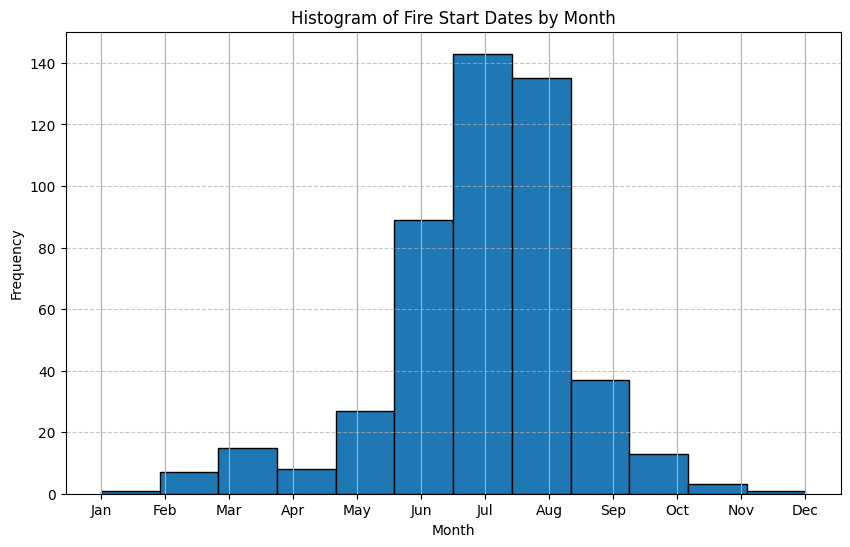

In [89]:
import matplotlib.pyplot as plt

# Ensure 'start_date' is in datetime format
df['start_date'] = pd.to_datetime(df['start_date'], errors='coerce')

# Drop rows with invalid or missing 'start_date'
df = df.dropna(subset=['start_date'])

# Plot the histogram
plt.figure(figsize=(10, 6))
df[df['start_year'] == 2016]['start_date'].dt.month.hist(bins=12, edgecolor='black')
plt.title('Histogram of Fire Start Dates by Month')
plt.xlabel('Month')
plt.ylabel('Frequency')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Estimated mean (mu): 7.0476190476190474
Estimated standard deviation (sigma): 1.4854371865195322


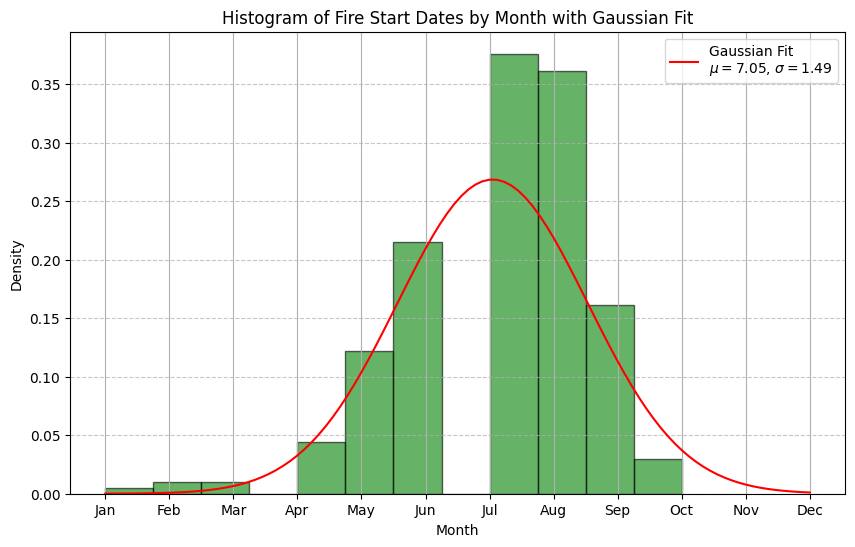

In [95]:
from scipy.stats import norm
import numpy as np

# Extract the month data for the histogram
fire_months = df[df['start_year'] == 2004]['start_date'].dt.month

# Fit a Gaussian distribution to the data
mu, sigma = norm.fit(fire_months)

# Print the learned parameters
print(f"Estimated mean (mu): {mu}")
print(f"Estimated standard deviation (sigma): {sigma}")

# Plot the histogram and the fitted Gaussian curve
plt.figure(figsize=(10, 6))
fire_months.hist(bins=12, density=True, alpha=0.6, color='g', edgecolor='black')

# Generate values for the Gaussian curve
x = np.linspace(1, 12, 100)
pdf = norm.pdf(x, mu, sigma)

# Plot the Gaussian curve
plt.plot(x, pdf, 'r-', label=f'Gaussian Fit\n$\mu={mu:.2f}$, $\sigma={sigma:.2f}$')
plt.title('Histogram of Fire Start Dates by Month with Gaussian Fit')
plt.xlabel('Month')
plt.ylabel('Density')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

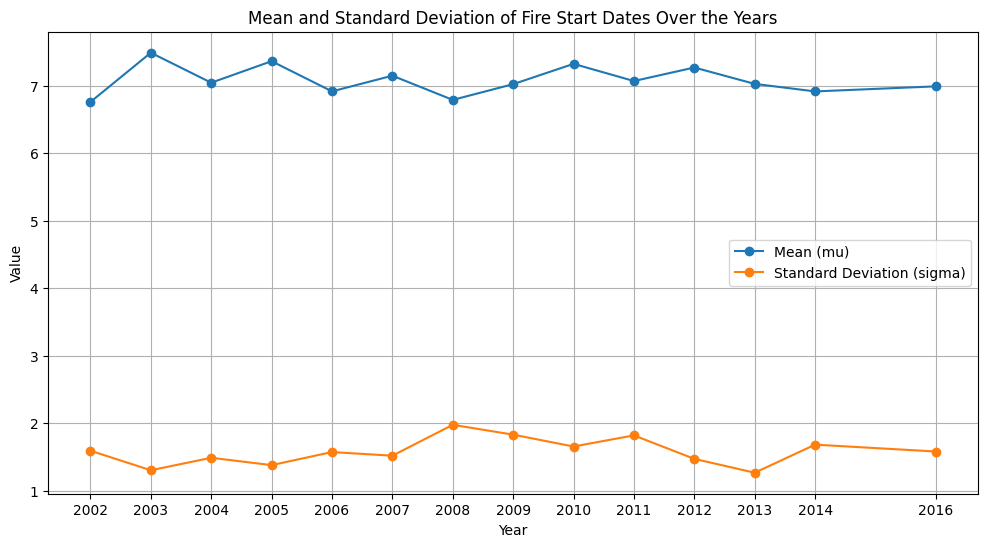

In [96]:
years = [2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2016]

def retrieve_mu_sigma(df, year):
    fire_months = df[df['start_year'] == year]['start_date'].dt.month
    mu, sigma = norm.fit(fire_months)
    return mu, sigma

# Retrieve mu and sigma for each year
mu_sigma_list = [retrieve_mu_sigma(df, year) for year in years]
mu_sigma_list
# Create a DataFrame for better visualization
mu_sigma_df = pd.DataFrame(mu_sigma_list, columns=['mu', 'sigma'], index=years)
mu_sigma_df
# Plot the mu and sigma values over the years
plt.figure(figsize=(12, 6))
plt.plot(mu_sigma_df.index, mu_sigma_df['mu'], marker='o', label='Mean (mu)')
plt.plot(mu_sigma_df.index, mu_sigma_df['sigma'], marker='o', label='Standard Deviation (sigma)')
plt.title('Mean and Standard Deviation of Fire Start Dates Over the Years')
plt.xlabel('Year')
plt.ylabel('Value')
plt.xticks(mu_sigma_df.index)
plt.legend()
plt.grid()
plt.show()

# Which of the 10 NICC-defined geographic areas requested the most helicopters for firefighting?

In [98]:
# Manually cleaned data from the image
region_totals_manual = {
    "Alaska Area": 19,
    "Eastern Area": 9,
    "Great Basin Area": 232,
    "National Interagency Coordination Center": 0,
    "Northern California Area": 81,
    "Northern Rockies Area": 112,
    "Northwest Area": 185,
    "Rocky Mountain Area": 39,
    "Southern Area": 49,
    "Southern California Area": 89,
    "Southwest Area": 65,
    "Other": 0,
    "Canada": 0
}

# Convert to DataFrame
df_cleaned = pd.DataFrame(region_totals_manual.items(), columns=["Region", "Total Helicopter Requests"])
# import ace_tools as tools; tools.display_dataframe_to_user(name="Cleaned Helicopter Requests by Region", dataframe=df_cleaned)
df_cleaned

,Region,Total Helicopter Requests
0,Alaska Area,19
1,Eastern Area,9
2,Great Basin Area,232
3,National Interagency Coordination Center,0
4,Northern California Area,81
5,Northern Rockies Area,112
6,Northwest Area,185
7,Rocky Mountain Area,39
8,Southern Area,49
9,Southern California Area,89


In [101]:
df_cleaned.loc[df_cleaned['Total Helicopter Requests'].idxmax()]

Region                       Great Basin Area
Total Helicopter Requests                 232
Name: 2, dtype: object

# What is the correlation between the proportion of generally unsafe air quality days according to the EPA and the amount of land affected by fires in 2024?

In [103]:
aqi_df = pd.read_csv('../input/annual_aqi_by_county_2024.csv')
aqi_df

,State,County,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days PM2.5,Days PM10
0,Alabama,Baldwin,2024,210,181,29,0,0,0,0,84,53,39,0,0,98,112,0
1,Alabama,Clay,2024,212,176,36,0,0,0,0,75,53,29,0,0,0,212,0
2,Alabama,DeKalb,2024,244,182,62,0,0,0,0,87,58,44,0,0,170,74,0
3,Alabama,Elmore,2024,144,142,2,0,0,0,0,58,47,37,0,0,144,0,0
4,Alabama,Etowah,2024,212,125,87,0,0,0,0,93,61,47,0,0,57,155,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
981,Wyoming,Sweetwater,2024,213,154,57,2,0,0,0,137,64,45,0,1,156,33,23
982,Wyoming,Teton,2024,244,158,85,1,0,0,0,105,67,47,0,0,208,33,3
983,Wyoming,Uinta,2024,182,182,0,0,0,0,0,22,13,6,0,0,0,0,182
984,Wyoming,Washakie,2024,176,163,13,0,0,0,0,71,47,9,0,0,0,176,0


In [106]:
aqi_df['good day proportion'] = aqi_df['Good Days'] / aqi_df['Days with AQI']

In [116]:
aqi_df_state = aqi_df.groupby(['State']).mean().reset_index()

/var/folders/mt/lv8dl5zj78n8fw343s4t1jmc0000gn/T/ipykernel_13527/4281353165.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aqi_df_state = aqi_df.groupby(['State']).mean().reset_index()


In [117]:
augmented_df = aqi_df_state.merge(df_combined[['State', 'Total Acres Burned', 'Population']], on='State', how='left')

# Display the augmented DataFrame
print(augmented_df)

                   State    Year  Days with AQI   Good Days  Moderate Days  \
0                Alabama  2024.0     174.533333  135.000000      39.400000   
1                 Alaska  2024.0     127.625000  106.250000      19.125000   
2                Arizona  2024.0     271.615385  166.000000      95.230769   
3               Arkansas  2024.0     182.545455  134.090909      47.454545   
4             California  2024.0     185.137255  114.882353      59.941176   
5               Colorado  2024.0     248.629630  167.370370      72.814815   
6            Connecticut  2024.0     173.125000  142.625000      24.875000   
7      Country Of Mexico  2024.0     274.000000  121.000000     150.000000   
8               Delaware  2024.0     172.333333  126.333333      45.000000   
9   District Of Columbia  2024.0     183.000000  118.000000      62.000000   
10               Florida  2024.0     195.578947  141.315789      53.684211   
11               Georgia  2024.0     239.724138  158.068966     

In [118]:
# Ensure the columns are numeric
augmented_df['good day proportion'] = pd.to_numeric(augmented_df['good day proportion'], errors='coerce')
augmented_df['Total Acres Burned'] = pd.to_numeric(augmented_df['Total Acres Burned'], errors='coerce')

# Calculate the correlation
correlation = augmented_df[['good day proportion', 'Total Acres Burned']].corr().iloc[0, 1]
print(f"Correlation between good day proportion and total acres burned: {correlation}")

Correlation between good day proportion and total acres burned: -0.040435478270181506


In [122]:
augmented_df['bad days'] = augmented_df['Unhealthy Days'] + augmented_df['Very Unhealthy Days'] + augmented_df['Hazardous Days']

In [123]:
augmented_df.corr()

/var/folders/mt/lv8dl5zj78n8fw343s4t1jmc0000gn/T/ipykernel_13527/813506074.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  augmented_df.corr()


,Year,Days with AQI,Good Days,Moderate Days,Unhealthy for Sensitive Groups Days,Unhealthy Days,Very Unhealthy Days,Hazardous Days,Max AQI,90th Percentile AQI,Median AQI,Days CO,Days NO2,Days Ozone,Days PM2.5,Days PM10,good day proportion,Total Acres Burned,Population,bad days
Year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Days with AQI,NaN,1.000000,0.844832,0.665358,0.190110,0.028427,-0.076376,-0.155776,0.381152,0.362687,0.549498,-0.183673,-0.003482,0.656627,0.398030,0.211302,-0.422109,-0.145064,0.063898,-0.003004
Good Days,NaN,0.844832,1.000000,0.165388,-0.080308,-0.111974,-0.185857,-0.254651,0.051039,-0.129628,0.181649,-0.147470,-0.024787,0.561138,0.452400,-0.092348,0.111420,-0.172251,-0.131585,-0.148693
Moderate Days,NaN,0.665358,0.165388,1.000000,0.386487,0.143037,0.070176,0.034213,0.586807,0.826317,0.768978,-0.151713,0.025354,0.419089,0.125212,0.498903,-0.928882,-0.066832,0.286089,0.135456
Unhealthy for Sensitive Groups Days,NaN,0.190110,-0.080308,0.386487,1.000000,0.652239,0.452636,0.393016,0.712069,0.632654,0.243255,0.128604,0.078274,0.262647,-0.303133,0.447952,-0.480510,0.260571,0.256902,0.661453
Unhealthy Days,NaN,0.028427,-0.111974,0.143037,0.652239,1.000000,0.727585,0.231932,0.534364,0.374988,-0.006501,0.270124,-0.080761,-0.107591,0.014947,0.251362,-0.240260,0.633753,0.398633,0.985286
Very Unhealthy Days,NaN,-0.076376,-0.185857,0.070176,0.452636,0.727585,1.000000,0.442835,0.290528,0.262791,0.004564,-0.050091,-0.058636,-0.102949,-0.003078,0.090344,-0.180752,0.620732,0.542863,0.819664
Hazardous Days,NaN,-0.155776,-0.254651,0.034213,0.393016,0.231932,0.442835,1.000000,0.333886,0.105815,-0.138207,-0.040994,-0.081620,-0.081944,-0.192679,0.233839,-0.103362,0.174411,0.085815,0.361319
Max AQI,NaN,0.381152,0.051039,0.586807,0.712069,0.534364,0.290528,0.333886,1.000000,0.698411,0.496331,-0.107272,0.099171,0.307199,-0.110259,0.504423,-0.631420,0.184939,0.213382,0.529814
90th Percentile AQI,NaN,0.362687,-0.129628,0.826317,0.632654,0.374988,0.262791,0.105815,0.698411,1.000000,0.757077,-0.086835,0.161292,0.412685,-0.232177,0.430555,-0.914452,0.077809,0.438892,0.369566
